In [1]:
! pip install pyro-ppl

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pyro
pyro.__version__

'1.7.0'

In [3]:
import sys
import os
import subprocess
import tarfile
import shutil
import types
import math
import pickle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import boda
from boda.generator import plot_tools

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from statsmodels.graphics.tsaplots import plot_acf

from scipy import spatial
from scipy.cluster import hierarchy


In [4]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20210623_102310__205717.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {right_flank.shape}')

Loaded model from 20210623_102310 in eval mode


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [7]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, left_flank, right_flank, n_samples=1, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('left_flank', left_flank.to(model.device))
        self.register_buffer('right_flank', right_flank.to(model.device))
        
        self.n_samples = n_samples
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def add_flanks(self, x):
        try:
            expand_left  = self.left_flank.expand(self.batch_size, -1, -1)
            expand_right = self.right_flank.expand(self.batch_size, -1, -1)
            return torch.cat([ expand_left, x, expand_right ], dim=-1)
        except (AttributeError, RuntimeError) as e:
            self.batch_size = x.shape[0]
            return self.add_flanks(x)
        
    def forward(self, x, keep_sample=False):
        hook = x.to(self.model.device)
        
        sample = F.gumbel_softmax(
            hook.unsqueeze(0).expand(self.n_samples,-1,-1,-1), 
            tau=1, 
            hard=True, 
            eps=1e-10, 
            dim=-2
        ).flatten(0,1)

        hook = self.add_flanks(sample)
        
        unflatten_tuple = (self.n_samples, self.batch_size//self.n_samples)
        
        '''
        samples = []
        for i in range(self.n_samples):
            samples.append(
                self.add_flanks( 
                    F.gumbel_softmax(hook, tau=1, hard=True, eps=1e-10, dim=1) 
                )
            )
        
        hook = torch.stack(samples, dim=0).flatten(0,1)

        unflatten_tuple = (self.n_samples, self.batch_size)
        '''
        
        hook = self.model(hook)
        
        if self.bias_cell is not None:
            hook = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
                     - hook[...,self.bias_cell].mul(self.bias_alpha)
        else:
            hook = boda.graph.utils.shannon_entropy(hook)

        hook = hook.unflatten(0, unflatten_tuple)
        
        if keep_sample:
            return {'total_energy': hook.mean(dim=0), 'sample': sample, 'sample_energy': hook}
        else:
            return hook.mean(dim=0)

In [ ]:
my_energy = MyEnergy(my_model, left_flank, right_flank, n_samples=10, bias_cell=0, bias_alpha=1.)

In [11]:
import pyro
import pyro.distributions as dist

def factor_model(Energy, prior_variance=5., batch_size=1, temp=1.0):
    
    insert_seq = pyro.sample(
        'insert_seq',
        dist.Normal(
            torch.tensor(0.).cuda().expand(batch_size,4,200),
            torch.tensor(prior_variance).cuda().expand(batch_size,4,200)
        ).to_event(1)
    )
    
    with pyro.plate('batch', batch_size):
        
        nll = Energy(insert_seq)
    
        pyro.factor(
            "approximate_likelihood",
            -nll.div(temp).mul(0)
        )
        
    return {"insert_seq": insert_seq, "energy": nll}

In [12]:
factor_model(my_energy)

{'insert_seq': tensor([[[  9.1167,  -6.0332,   3.1227,   4.4472,   1.8565,   8.5580,   4.0583,
            -2.7738,  -2.5543,  -2.3307,   2.7558,   3.0774,   6.0822,   0.7146,
            -1.3819,  -4.6850,  -6.1988,   1.4651,  -2.7543,   8.7419,   4.0453,
             2.4830,   7.2005,  -6.1068,   3.0355,   6.3564,  -2.4806,  -5.4107,
             4.0110,  -7.4955,   2.7084,  -7.3485,  -6.1748,  -0.3082,  10.4132,
             4.4969,   4.9911,  -0.1372,   6.4558,   4.9254,   5.5983,  -4.9944,
             0.1021,  -5.4566,   3.8700,   5.7862,   4.7009,   7.0157,   4.2889,
            -0.6703,   4.0718,   0.6703,  12.7219,  -3.2507,   2.0109,  -2.1967,
            12.2443,   3.3254, -12.6165,   2.8090,   1.9563,  -5.2500,   5.0372,
            -7.1765,   3.5366,  -5.5014,   5.0897,   1.1850,   8.5572,   3.8156,
             2.3889,   2.3639,  -0.2972,  -2.8648,   3.1490,   6.5885,  -3.0675,
             1.2826,  -3.5102,   6.1625,  -1.3558,   9.5088,   7.4017,  -3.0351,
            -2

In [13]:
from pyro.infer import MCMC, NUTS

pyro.clear_param_store()

def conditioned_model(model, energy, variance, batch_size, temp):
    return factor_model(energy, variance, batch_size, temp)

nuts_kernel = NUTS(conditioned_model, max_tree_depth=7, target_accept_prob=0.65)

mcmc = MCMC(
    nuts_kernel,
    num_samples=200,
    warmup_steps=200,
    num_chains=1,
)

mcmc.run(factor_model, my_energy, 10., 4, 1.)
mcmc.summary()

Sample: 100%|██████████| 400/400 [01:17,  5.19it/s, step size=2.68e-01, acc. prob=0.735]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
  insert_seq[0,0,0]     -0.13      9.94     -0.62    -17.22     13.31    225.72      1.00
  insert_seq[0,0,1]      0.46     10.01      0.81    -15.85     15.17    306.56      1.00
  insert_seq[0,0,2]      1.01     10.80      1.58    -14.47     18.06    139.67      1.00
  insert_seq[0,0,3]      0.58     10.86      0.41    -15.66     18.06    333.26      1.00
  insert_seq[0,0,4]     -0.98      9.55     -0.92    -17.66     13.84    175.09      1.00
  insert_seq[0,0,5]      0.14     10.08      0.37    -17.01     14.88    298.38      1.00
  insert_seq[0,0,6]      0.56      9.80      0.05    -18.46     14.45    324.07      1.00
  insert_seq[0,0,7]      0.04      9.75     -0.07    -14.95     14.94    161.56      1.00
  insert_seq[0,0,8]     -0.14      8.84     -0.67    -14.89     15.22    426.20      1.00
  insert_seq[0,0,9]     -0.51      9.27     -0.80    -14.55     14.88    221.45      1.00
 insert_s

insert_seq[0,3,140]      0.23     11.10     -0.93    -16.49     19.61    455.61      1.00
insert_seq[0,3,141]      0.08     10.00     -0.22    -16.95     15.66    315.16      1.00
insert_seq[0,3,142]      0.15      9.07     -0.05    -13.46     14.79    461.36      1.00
insert_seq[0,3,143]     -0.30     10.99     -0.94    -18.73     16.69    280.55      1.00
insert_seq[0,3,144]     -0.30      9.11      0.57    -14.91     12.82    340.39      1.00
insert_seq[0,3,145]     -0.50     11.04     -1.19    -18.09     17.71    340.34      1.00
insert_seq[0,3,146]      0.20      9.36      0.29    -15.47     13.53    316.47      1.00
insert_seq[0,3,147]     -0.51     10.74     -1.37    -16.20     18.19    255.33      1.01
insert_seq[0,3,148]     -0.76      9.91     -1.33    -14.33     17.54    226.78      1.00
insert_seq[0,3,149]     -1.16      9.84     -1.06    -16.13     15.44    137.31      1.00
insert_seq[0,3,150]     -0.12      9.73      0.40    -16.13     15.49    159.91      1.00
insert_seq

 insert_seq[1,3,75]     -0.69      9.77     -0.51    -21.51     11.41    556.77      1.00
 insert_seq[1,3,76]      0.02     11.20     -0.46    -17.52     18.50    728.92      1.00
 insert_seq[1,3,77]     -0.94      9.48     -1.47    -17.80     13.17    250.87      1.00
 insert_seq[1,3,78]      1.17     12.12      0.87    -21.33     18.87    635.12      1.00
 insert_seq[1,3,79]     -0.77     10.56     -1.08    -17.32     15.10    409.11      1.00
 insert_seq[1,3,80]      0.96      9.47      0.80    -17.37     14.37    385.41      1.00
 insert_seq[1,3,81]     -0.48      9.91     -1.92    -14.55     18.93    158.69      1.01
 insert_seq[1,3,82]      0.25     10.74     -0.50    -16.40     17.21    122.66      1.00
 insert_seq[1,3,83]     -0.65     10.70     -0.07    -19.67     13.00    225.68      1.00
 insert_seq[1,3,84]     -0.85      9.95     -0.46    -18.73     13.20    290.47      1.00
 insert_seq[1,3,85]     -0.21     10.01     -0.47    -15.80     14.06    513.40      1.00
 insert_se

 insert_seq[2,3,29]     -0.40     10.00      0.22    -17.73     13.86    103.10      1.02
 insert_seq[2,3,30]      1.18      9.91      0.90    -14.66     17.72    217.59      1.00
 insert_seq[2,3,31]      1.02     10.33      1.72    -15.29     18.86    192.37      1.00
 insert_seq[2,3,32]     -0.90      9.93     -0.56    -15.06     15.30    206.24      1.00
 insert_seq[2,3,33]      0.57     10.63      0.74    -14.85     17.30    224.51      1.00
 insert_seq[2,3,34]     -0.39      9.28      0.59    -16.13     13.49    349.43      1.00
 insert_seq[2,3,35]     -0.53      9.68     -0.81    -16.33     14.92    187.76      1.00
 insert_seq[2,3,36]     -0.25     11.43      0.09    -18.88     18.86    156.01      1.00
 insert_seq[2,3,37]     -0.70     11.25     -0.53    -18.86     18.72    923.48      0.99
 insert_seq[2,3,38]      0.95      9.96      1.24    -13.72     16.09    313.89      1.00
 insert_seq[2,3,39]      0.89     10.38      0.72    -15.93     16.96    263.01      1.00
 insert_se

insert_seq[3,2,163]      0.19     11.80      0.41    -17.88     17.27    292.36      1.00
insert_seq[3,2,164]     -0.20     10.75     -0.52    -17.45     17.57    725.39      1.00
insert_seq[3,2,165]      0.44      9.64     -0.76    -12.25     18.44    194.28      1.00
insert_seq[3,2,166]      0.55      9.03      0.61    -13.09     13.74    934.04      0.99
insert_seq[3,2,167]      0.00     10.04      0.15    -18.18     14.28    328.86      1.00
insert_seq[3,2,168]     -0.25      9.31      0.32    -15.40     13.87    229.36      1.01
insert_seq[3,2,169]      1.07      9.80      0.41    -15.95     14.87    416.97      0.99
insert_seq[3,2,170]     -0.12     10.65      0.79    -18.40     15.94    296.27      1.00
insert_seq[3,2,171]     -0.11      9.87     -0.66    -14.88     18.49    484.70      1.00
insert_seq[3,2,172]      0.97     10.50      0.74    -14.52     18.70    198.37      1.00
insert_seq[3,2,173]      1.72      9.73      1.13    -13.80     17.86    197.32      1.00
insert_seq

In [15]:
_ = [ print(f'{k}: {v.shape}') for k, v in mcmc.get_samples().items() ]

insert_seq: torch.Size([200, 4, 4, 200])


In [29]:
old_n = my_energy.n_samples
old_bias = my_energy.bias_cell
my_energy.n_samples = 100
#my_energy.bias_cell = None

with torch.no_grad():
    sample_data = [ { k: v.cpu() for k,v in my_energy( sample.unsqueeze(0), True ).items() } 
                    for sample in mcmc.get_samples()['insert_seq'].flatten(0,1) ]
    sample_energy = torch.cat( [ sample['sample_energy'] for sample in sample_data ], dim=1 )
    sample_seqs   = torch.stack( [ sample['sample'] for sample in sample_data ], dim=0 ).transpose(0,1)
my_energy.n_samples = old_n
my_energy.bias_cell = old_bias

In [ ]:
with open('HepG2_tau_mcmc_samples.pkl', 'wb') as f:
    pickle.dump(mcmc.get_samples()['insert_seq'].cpu().numpy(), file=f)
    
with open('HepG2_tau_energy_samples.pkl', 'wb') as f:
    pickle.dump(sample_energy.cpu().numpy(), file=f)
    
with open('HepG2_tsu_sequence_samples.pkl', 'wb') as f:
    pickle.dump(sample_seqs.bool().cpu().numpy(), file=f)

In [27]:
with open('K562_tau_mcmc_samples.pkl', 'rb') as f:
    mcmc_samples = pickle.load(f)
    
with open('K562_tau_energy_samples.pkl', 'rb') as f:
    sample_energy = torch.tensor( pickle.load(f) )
    
with open('K562_tsu_sequence_samples.pkl', 'rb') as f:
    sample_seqs   = torch.tensor( pickle.load(f) ).float()

FileNotFoundError: [Errno 2] No such file or directory: 'K562_tsu_sequence_samples.pkl'

In [30]:
sample_energy.shape

torch.Size([100, 800])

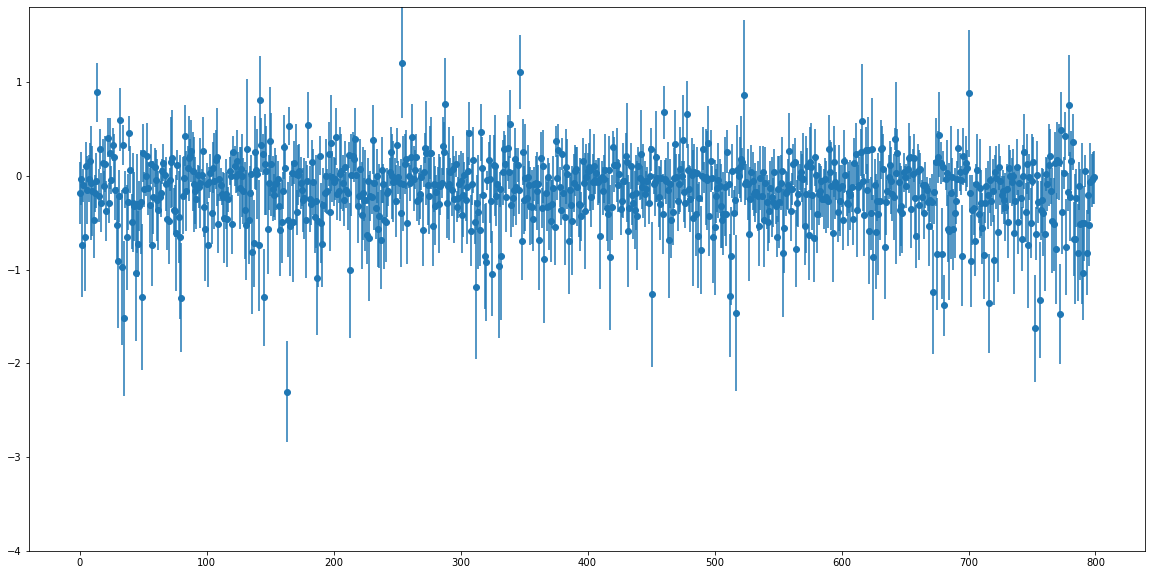

In [31]:
plt.figure(figsize=(20,10))

plt.scatter( np.arange(sample_energy.shape[1]), sample_energy.mean(0) )
plt.vlines( np.arange(sample_energy.shape[1]), 
            sample_energy.mean(0) - sample_energy.std(0), 
            sample_energy.mean(0) + sample_energy.std(0) )

plt.ylim(bottom=-4.,top=1.8)
plt.show()

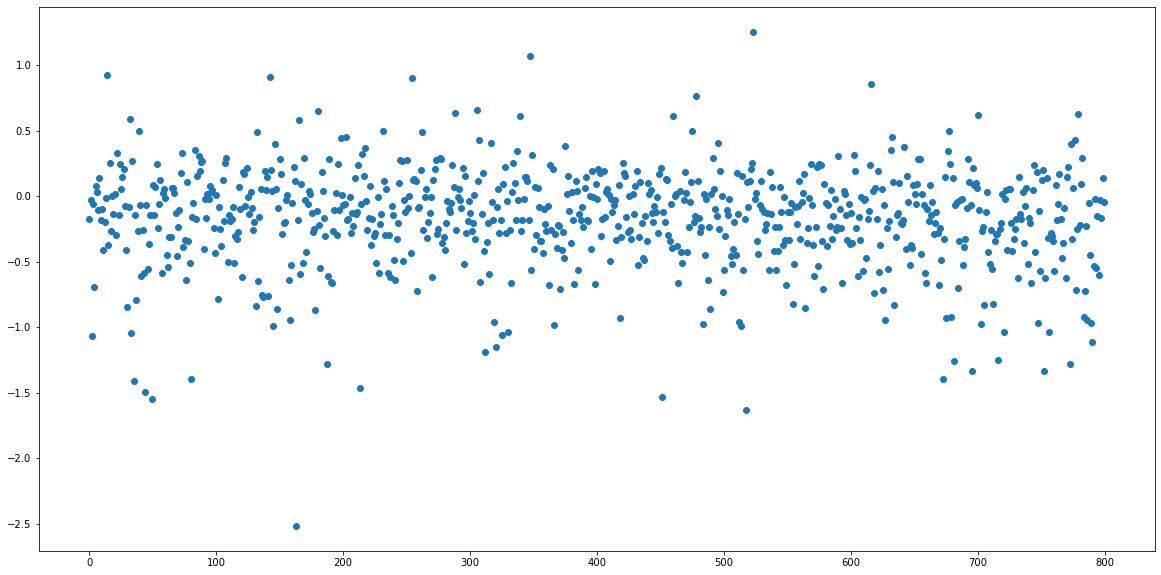

In [19]:
plt.figure(figsize=(20,10))

plt.scatter( np.arange(sample_energy.shape[1]), sample_energy.mean(0) )

#plt.ylim(bottom=0.)
plt.show()

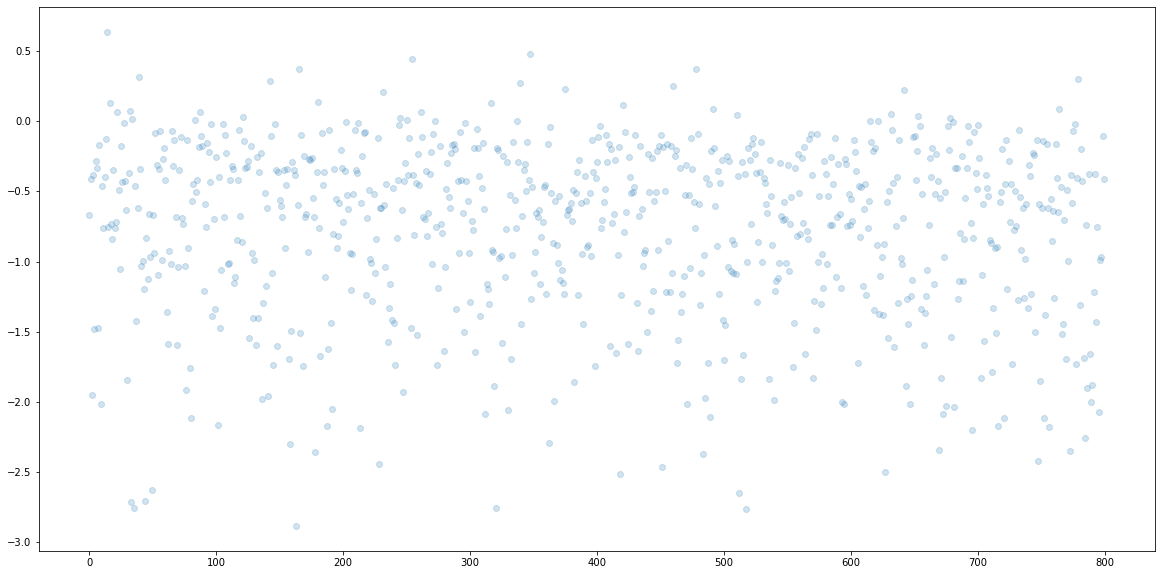

In [20]:
plt.figure(figsize=(20,10))

plt.scatter( np.arange(sample_energy.shape[1]), sample_energy.min(0).values, alpha=0.2 )

#plt.ylim(bottom=0.)
plt.show()

In [21]:
sample_energy.min(0).values < 0.2

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [22]:
sample_seqs.shape

torch.Size([10, 800, 4, 200])

In [23]:
best_seqs = torch.stack([ seqs[best] for seqs, best in zip( sample_seqs.transpose(0,1), sample_energy.argmin(0)) ], dim=0)
best_seqs = torch.cat([ left_flank.expand(*best_seqs.shape), best_seqs, right_flank.expand(*best_seqs.shape) ],dim=-1)

In [24]:
results = []
with torch.no_grad():
    for i, batch in enumerate( torch.utils.data.DataLoader( torch.utils.data.TensorDataset(best_seqs), batch_size=16 ) ):
        results.append( my_model(batch[0].cuda()).cpu() )
    
results = torch.cat(results, dim=0)

In [26]:
for i, seq in enumerate(best_seqs[sample_energy.min(0).values < -2.,:,200:400]):
    print(f">seq_{i}")
    print( "".join([ boda.common.constants.STANDARD_NT[index] for index in seq.argmax(0) ]) )

>seq_0
CACTCTGTCGACCCTAAACCCCACCAGTGCAACCCAAAAACTGGGGAGTTTTATCCCTATTTACGCAACCTTTCTCTGGACATACTGAGAGAGATATCTAATCACGTTAGCACGCATCCGCTATTGTCACAGCAGTCACCAGCAGGGAGTCGAAAAATGGCGCATTTCTTCCTCACGTCTCCTGTCACACAGTCGCACCC
>seq_1
AGTCTGATGACACACAGCCGTTTACGTATTATTTGAGTGGCCGGCTTAGGAAGGCTAATAGTGATAAGAGGCTTTCCTCCGCGTAACAACCTATTGCTTGTCGGGATACCGCGGCTCAGCTCCTGAGGCCGACTCGAGGGTAGCCTACAGTCGAGAATTAGGGGCTCACAATCGTTCTGTATCACATCGATATACCACAA
>seq_2
TCCTCTCACTCTTGCACGTGCTTCAGGCCCATTGTTATGGCGTCAAATCAGCCAGCGTGCGACGAGCACAGCTCTCCATCACAATATTGCTTGCGTTGTAGAATACAGCATTGACACTAACTACATGCGTCGTGTTGTTATCTCAAGTCCCAACAGAACCTGCTGTTGTCAAGCCGACCAGACTCGTCCACGGGAAAAGA
>seq_3
ACTAGAATTAGGACTCCCTTCTCTGATGTCGTCATCGTATTGCTCTGGCTAGGCGCGATCTTCCCGCACTTTTATGAGTAACGTGAAGTTTATCTTTGAGCTCAACACGGCTCGTGGTGGGCGGGGTAGCGAACATTATCGACTAAGCCGATCCCGCCTTGTTGCAGTATATATCAGCTCTCATCATTAGAATAGGCTGA
>seq_4
TTATCTCAAGGAACAATTCACCGCAATCATGCTCCCCACCCTATTCCTGAGGCCTGCCTTAAGTACTAACCTCAGCGGACCACGTCCTTTGGCTGGAGTATCGCCCCCTTGTTATCTGCCGACGCGCGGTCGGCCCTTGTATAATTTAATCAGCCGGAAGA

In [25]:
boda.graph.utils.shannon_entropy( results[sample_energy.min(0).values < -2.] )

tensor([0.5247, 0.4273, 0.0933, 0.0806, 0.5303, 0.5890, 0.4829, 0.4770, 0.6030,
        0.4543, 0.5592, 0.3341, 0.4684, 0.4665, 0.3453, 0.5539, 0.6077, 0.6120,
        0.3876, 0.5975, 0.5900, 0.5829, 0.3754, 0.4672, 0.5002, 0.4442, 0.3768,
        0.3340, 0.5091, 0.4580, 0.6402, 0.6057, 0.5258, 0.3833, 0.5734, 0.6259,
        0.2550, 0.5409, 0.4750, 0.4249, 0.3097, 0.4811, 0.2340, 0.5390, 0.6365,
        0.3834, 0.4608, 0.3244, 0.5000, 0.4225, 0.3527, 0.3149, 0.1251, 0.4340,
        0.4553, 0.5494, 0.4647, 0.3280, 0.5594, 0.5542, 0.2074, 0.4235, 0.3360,
        0.6511, 0.4615, 0.5137, 0.5587, 0.5594, 0.6179, 0.5292, 0.5071, 0.4435,
        0.3450, 0.4129, 0.6083, 0.4732, 0.3027, 0.3280, 0.5981, 0.2028, 0.4873,
        0.6240, 0.3385, 0.5470, 0.4622, 0.2194, 0.3465, 0.3911, 0.5187, 0.6050,
        0.6167, 0.6533, 0.5829, 0.5891, 0.4613, 0.5528, 0.4253, 0.1917, 0.5802,
        0.5575, 0.3876, 0.6547, 0.6131, 0.3994, 0.4949, 0.4655, 0.6038, 0.4942,
        0.3469, 0.4398, 0.5642, 0.4252, 

In [26]:
sample_energy.min()

tensor(-5.0428)

In [27]:
(sample_energy.min(0).values < 0.6).sum()

tensor(1600)

In [28]:
(sample_energy.min(0).values <= 0.2).sum()

tensor(1600)

In [29]:
(sample_energy.min(0).values < 0.1).sum()

tensor(1600)

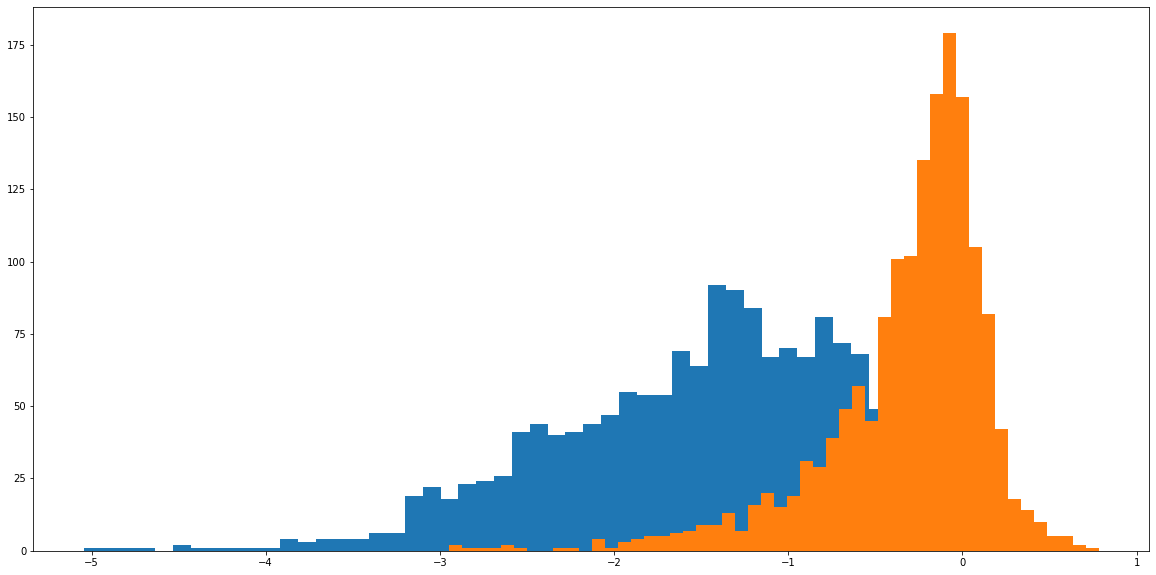

In [32]:
plt.figure(figsize=(20,10))
plt.hist(sample_energy.min(0).values.numpy(), bins=50)
plt.hist(sample_energy.mean(0).numpy(), bins=50)
plt.show()

In [46]:
rand_id = np.random.randint(low=0, high=200)
seq_traj = mcmc.get_samples()['insert_seq'][:,2,:,:]
print(f'param key: {rand_id}')
plt.figure(figsize=(20,10))
for i in range(4):
    plt.plot(np.arange(seq_traj.shape[0]),seq_traj[:,i,rand_id].cpu().numpy(),alpha=0.6)
plt.legend(['A','G','T','C'])
plt.show()

NameError: name 'mcmc' is not defined

In [27]:
sample_seqs.shape

torch.Size([8000, 100, 4, 200])

In [28]:
sample_energy.shape

torch.Size([100, 8000])

In [29]:
best_seqs = []
for i,sample in enumerate(sample_seqs):
    best_seqs.append( sample[ sample_energy.argmin(0)[i] ] )
    
best_seqs = torch.stack(best_seqs, dim=0)

In [30]:
for a_seq in best_seqs[sample_energy.min(0).values <= 0.1]:
    plot_tools.logits_to_dms(a_seq.mul(20.))
    plt.show()
    break

In [31]:
pentamer_scan = boda.common.utils.KmerFilter(k=4)
kmer_content  = pentamer_scan( best_seqs[sample_energy.min(0).values <= 0.2] ).max(dim=-1).values

In [32]:
def jaccard_index(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            inter = torch.logical_and(x_batch,y_batch).sum(-1)
            union = torch.logical_or(x_batch,y_batch).sum(-1)
            ji = inter / union
            row.append(ji.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

def euclidean_distance(x, y, max_batch_size=1024, dtype=torch.float, device='cpu'):
    assert len(x.shape) == 2, f"expected x as 2D tensor, instead got shape {x.shape}"
    assert len(y.shape) == 2, f"expected y as 2D tensor, instead got shape {y.shape}"
    matrix = []
    x_loader = torch.utils.data.DataLoader( x, batch_size=max_batch_size )
    y_loader = torch.utils.data.DataLoader( y, batch_size=max_batch_size )
    for x_batch in x_loader:
        row = []
        x_batch = x_batch.unsqueeze(1)
        for y_batch in y_loader:
            y_batch = y_batch.unsqueeze(0)
            dist  = (x_batch - y_batch).pow(2).sum(-1).pow(0.5)
            row.append(dist.type(dtype).to(device))
        matrix.append( torch.cat(row,dim=-1) )
    return torch.cat(matrix,dim=0)

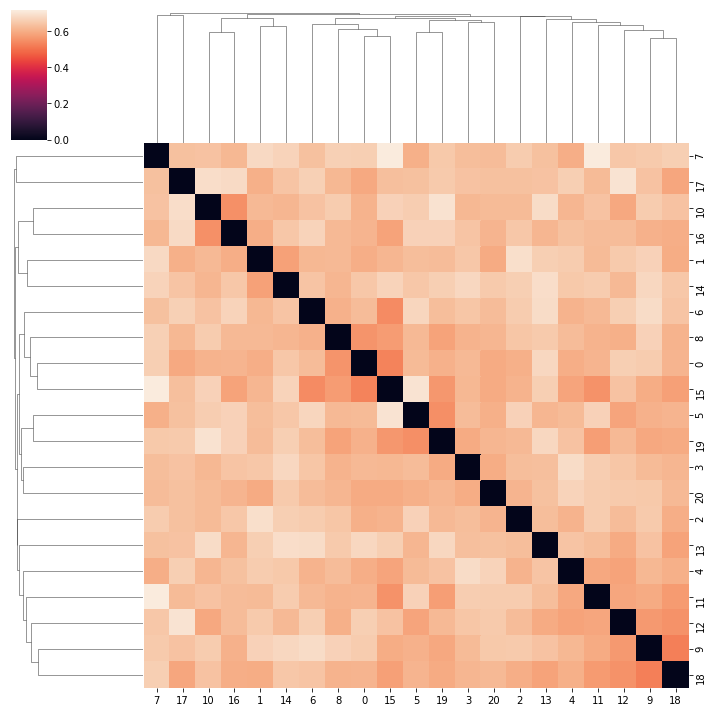

In [33]:
jac_res = jaccard_index(kmer_content, kmer_content, max_batch_size=512, dtype=torch.half)

DF_dism = 1 - jac_res.cpu().numpy()   # distance matrix
linkage = hierarchy.linkage(spatial.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

0.14222583174705505


<AxesSubplot:xlabel='celltype', ylabel='predicted activity'>

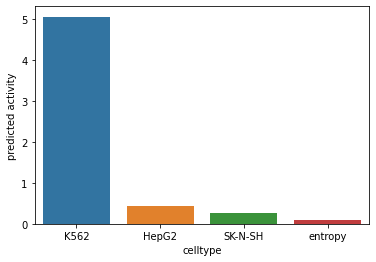

In [104]:
fake_data = {'predicted activity':[5.0579, 0.43359, 0.2743, 0.101874], 'celltype':['K562','HepG2','SK-N-SH', 'entropy']}
print(boda.graph.utils.shannon_entropy( torch.tensor(fake_data['predicted activity']).unsqueeze(0) ).item())
sns.barplot(data=pd.DataFrame(fake_data),x='celltype',y='predicted activity')

1.1192623376846313


<AxesSubplot:xlabel='celltype', ylabel='activity'>

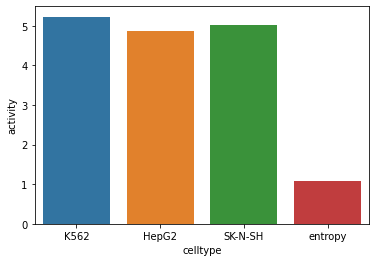

In [76]:
fake_data = {'activity':[5.2326, 4.8814, 5.0231, 1.088059], 'celltype':['K562','HepG2','SK-N-SH', 'entropy']}
print(boda.graph.utils.shannon_entropy( torch.tensor(fake_data['activity']).unsqueeze(0) ).item())
sns.barplot(data=pd.DataFrame(fake_data),x='celltype',y='activity')

In [74]:
print(boda.graph.utils.shannon_entropy( torch.tensor([10.,10.,10.]).unsqueeze(0) ).item())

1.0986123085021973


In [61]:
for i in range(20):
    print("".join(list(np.random.choice(['A','T','G','C'],(14,)))))
        

GCCGGTTGTGCTCG
CCCTTCACAGACAT
GTAGCACCAGAACC
CGCCCGGCCCTGAG
AGACTGCCGTTATT
TTGGCACCGGTAGC
GGCCACACCACAAG
TTGGGAAATACATG
GGTTTTGCCTATAG
TCTTTTACTCAAAT
TGACACTCTGCATC
TCACACAGAAAAGA
TTAGCTAATGGGGG
GATTGGCCCTCCTA
CGTATGTGTCAAAT
AAGCGCCGGCAGGG
TCTGTCGTCAGCCG
TTAACTACTTGCCA
ATAGTATGCGCTCT
GGCCAATCACCACG


In [77]:
! gsutil cp gs://syrgoth/data/MPRA_UKBB_BODA.txt ./

Copying gs://syrgoth/data/MPRA_UKBB_BODA.txt...
\ [1 files][107.1 MiB/107.1 MiB]                                                
Operation completed over 1 objects/107.1 MiB.                                    


In [80]:
check_data = pd.read_table('MPRA_UKBB_BODA.txt',header=0,sep=' ')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [88]:
true_entropy_sample = boda.graph.utils.shannon_entropy( torch.tensor(check_data.sample(40000).loc[:,['K562_mean','HepG2_mean','SKNSH_mean']].values,dtype=torch.float) )

In [93]:
true_entropy_sample.shape == sample_energy.min(0).values.shape

True

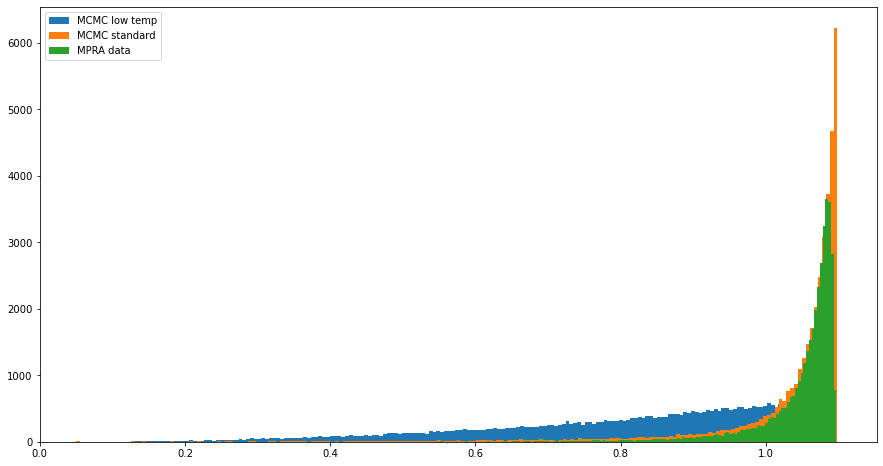

In [96]:
plt.figure(figsize=(15,8))
plt.hist(sample_energy.min(0).values.numpy(), bins=200)
plt.hist(true_entropy_sample.numpy(), bins=200)
plt.hist(sample_energy.mean(0).numpy(), bins=200)
plt.xlim(left=0.)
plt.legend(['MCMC low temp', 'MCMC standard', 'MPRA data'])
plt.show()

In [ ]:
reps=1
my_energy.n_samples = 1
with torch.no_grad():
    plt.figure(figsize=(20,10))
    for rep in range(reps):
        energy_traj = torch.stack(
            [ my_energy(sample.unsqueeze(0)).cpu() for sample in mcmc.get_samples()['insert_seq'].flatten(0,1) ],
            dim=0
        ).squeeze()
        plt.scatter( np.arange(energy_traj.numel()), energy_traj.numpy() )
    plt.ylim(bottom=0.)
    plt.show()
    
my_energy.n_samples = 10

In [ ]:
reps=1
my_energy.n_samples = 1
with torch.no_grad():
    plt.figure(figsize=(20,10))
    for rep in range(reps):
        energy_traj = torch.stack(
            [ my_energy(sample.unsqueeze(0)).cpu() for sample in mcmc.get_samples()['insert_seq'].flatten(0,1) ],
            dim=0
        ).squeeze()
        plt.scatter( np.arange(energy_traj.numel()), energy_traj.numpy() )
    plt.ylim(bottom=0.)
    plt.show()
    
my_energy.n_samples = 10

In [ ]:
reps=1
with torch.no_grad():
    plt.figure(figsize=(20,10))
    for rep in range(reps):
        energy_traj = torch.stack(
            [ my_energy(sample.unsqueeze(0)).cpu() for sample in mcmc.get_samples()['insert_seq'].flatten(0,1) ],
            dim=0
        ).squeeze()
        plt.plot( np.arange(energy_traj.numel()), energy_traj.numpy() )
    plt.show()

In [ ]:
print(sum(energy_traj <= 0.65))
print(energy_traj.argmin())

In [ ]:
mcmc.get_samples()['insert_seq'].flatten(0,1)[energy_traj.argmin()]

In [ ]:
plot_tools.logits_to_dms(mcmc.get_samples()['insert_seq'].flatten(0,1)[energy_traj.argmin()])

In [ ]:
for seq,score in zip(mcmc.get_samples()['insert_seq'].flatten(0,1)[energy_traj <= 0.65],energy_traj[energy_traj <= 0.65]):
    print(score)
    plot_tools.logits_to_dms(seq)
    plt.show()

In [ ]:
with torch.no_grad():
    energy_traj = my_energy( mcmc.get_samples()['insert_seq'].squeeze() ).cpu()
    plt.figure(figsize=(20,10))
    plt.plot( np.arange(energy_traj.numel()), energy_traj.numpy() )

In [ ]:
F.gumbel_softmax(torch.randn(2,3), tau=1, hard=True, eps=1e-10, dim=1)

In [ ]:
class GumbelSoftmaxParameters(ParamsBase):
    def __init__(self,
                 data, 
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 token_dim=1,
                 cat_axis=-1,
                 n_samples=1,
                 tau=1.,
                 prior_var=1.,
                 use_norm=False,
                 use_affine=False
                ):
        
        super().__init__()
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.n_samples = n_samples
        self.tau = tau
        self.prior_var = prior_var
        
        self.use_norm = use_norm
        self.use_affine = use_affine
        
        self.num_classes= self.theta.shape[self.token_dim]
        self.n_dims     = len(self.theta.shape)
        self.repeater   = [ 1 for i in range(self.n_dims) ]
        self.batch_size = self.theta.shape[self.batch_dim]
        
        if self.use_norm:
            self.norm = nn.InstanceNorm1d(num_features=self.num_classes, 
                                          affine=self.use_affine)
        else:
            self.norm = nn.Identity()
        
    @property
    def shape(self):
        return self.get_logits().shape
    
    def get_logits(self):
        my_attr = [ getattr(self, x) for x in ['left_flank', 'theta', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def get_sample(self):
        hook = self.norm( self.theta )
        hook = [ F.gumbel_softmax(hook, tau=self.tau, hard=True, dim=1) 
                 for i in range(self.n_samples) ]
        return torch.stack(hook, dim=0)
    
    def forward(self):
        pieces = []
        
        if self.left_flank is not None:
            pieces.append( self.left_flank.repeat(self.n_samples, *self.repeater) )
            
        pieces.append( self.get_sample() )
        
        if self.right_flank is not None:
            pieces.append( self.right_flank.repeat(self.n_samples, *self.repeater) )
            
        return torch.cat( pieces, axis=self.cat_axis ).flatten(0,1)
        
    def rebatch(self, input):
        return input.unflatten(0, (self.n_samples, self.batch_size)).mean(dim=0)


In [6]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, left_flank, right_flank, n_samples=1, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('left_flank', left_flank.to(model.device))
        self.register_buffer('right_flank', right_flank.to(model.device))
        
        self.n_samples = n_samples
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def add_flanks(self, x):
        try:
            expand_left  = self.left_flank.expand(self.batch_size, -1, -1)
            expand_right = self.right_flank.expand(self.batch_size, -1, -1)
            return torch.cat([ expand_left, x, expand_right ], dim=-1)
        except (AttributeError, RuntimeError) as e:
            self.batch_size = x.shape[0]
            return self.add_flanks(x)
        
    def forward(self, x, keep_sample=False):
        hook = x.to(self.model.device)
        
        sample = F.gumbel_softmax(
            hook.unsqueeze(0).expand(self.n_samples,-1,-1,-1), 
            tau=1, 
            hard=True, 
            eps=1e-10, 
            dim=-2
        ).flatten(0,1)

        hook = self.add_flanks(sample)
        
        unflatten_tuple = (self.n_samples, self.batch_size//self.n_samples)
        
        '''
        samples = []
        for i in range(self.n_samples):
            samples.append(
                self.add_flanks( 
                    F.gumbel_softmax(hook, tau=1, hard=True, eps=1e-10, dim=1) 
                )
            )
        
        hook = torch.stack(samples, dim=0).flatten(0,1)

        unflatten_tuple = (self.n_samples, self.batch_size)
        '''
        
        hook = self.model(hook)
        
        if self.bias_cell is not None:
            hook = boda.graph.utils.shannon_entropy(hook) +\
                   hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]] \
                     .mean(-1).mul(self.bias_alpha).clamp(-1)
        else:
            hook = boda.graph.utils.shannon_entropy(hook)

        hook = hook.unflatten(0, unflatten_tuple)
        
        if keep_sample:
            return {'total_energy': hook.mean(dim=0), 'sample': sample, 'sample_energy': hook}
        else:
            return hook.mean(dim=0)